In [49]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb

# Data Cleaning/Feature Engineering

In [2]:
# Read in data
year1 = pd.read_csv("year1.csv")
year2 = pd.read_csv("year2.csv")
year3 = pd.read_csv("year3.csv")
year1.head()

,season,pitch_id,release_speed,batter,pitcher,description,stand,p_throws,pitch_type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot
0,1,2697762.0,93.800003,5782,5738,ball,R,R,SI,1,1,-0.98,0.72,-1.23,4.10,3.70,1.82
1,1,2697773.0,95.599998,5782,5738,foul,R,R,FF,3,2,-0.38,0.96,-0.45,3.10,3.41,1.56
2,1,2697902.0,94.800003,5782,5842,foul,R,R,FF,1,0,-0.62,1.16,0.31,2.40,3.41,1.56
3,1,2697993.0,87.300003,5782,5041,ball,R,R,SL,2,1,0.82,-0.06,1.11,2.21,3.70,1.73
4,1,2697995.0,98.599998,5782,5041,called_strike,R,R,FF,3,1,-0.33,0.95,-0.35,3.39,3.70,1.70


In [3]:
# Concat into df
df = pd.concat([year1, year2], ignore_index=True)
df.head()

,season,pitch_id,release_speed,batter,pitcher,description,stand,p_throws,pitch_type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot
0,1,2697762.0,93.800003,5782,5738,ball,R,R,SI,1,1,-0.98,0.72,-1.23,4.10,3.70,1.82
1,1,2697773.0,95.599998,5782,5738,foul,R,R,FF,3,2,-0.38,0.96,-0.45,3.10,3.41,1.56
2,1,2697902.0,94.800003,5782,5842,foul,R,R,FF,1,0,-0.62,1.16,0.31,2.40,3.41,1.56
3,1,2697993.0,87.300003,5782,5041,ball,R,R,SL,2,1,0.82,-0.06,1.11,2.21,3.70,1.73
4,1,2697995.0,98.599998,5782,5041,called_strike,R,R,FF,3,1,-0.33,0.95,-0.35,3.39,3.70,1.70


In [4]:
df['description'].unique()

array(['ball', 'foul', 'called_strike', 'blocked_ball', 'hit_into_play',
       'hit_by_pitch', 'swinging_strike', 'foul_tip', 'foul_bunt',
       'swinging_strike_blocked', 'missed_bunt', 'pitchout',
       'bunt_foul_tip', 'foul_pitchout'], dtype=object)

In [5]:
# swing column (repsonse)
swings_list = ['foul','hit_into_play','swinging_strike', 'foul_tip', 'foul_bunt',
       'swinging_strike_blocked', 'missed_bunt',
       'bunt_foul_tip', 'foul_pitchout']
df['swing'] = df['description'].apply(lambda x: 1 if x in swings_list else 0)
df.head()

,season,pitch_id,release_speed,batter,pitcher,description,stand,p_throws,pitch_type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot,swing
0,1,2697762.0,93.800003,5782,5738,ball,R,R,SI,1,1,-0.98,0.72,-1.23,4.10,3.70,1.82,0
1,1,2697773.0,95.599998,5782,5738,foul,R,R,FF,3,2,-0.38,0.96,-0.45,3.10,3.41,1.56,1
2,1,2697902.0,94.800003,5782,5842,foul,R,R,FF,1,0,-0.62,1.16,0.31,2.40,3.41,1.56,1
3,1,2697993.0,87.300003,5782,5041,ball,R,R,SL,2,1,0.82,-0.06,1.11,2.21,3.70,1.73,0
4,1,2697995.0,98.599998,5782,5041,called_strike,R,R,FF,3,1,-0.33,0.95,-0.35,3.39,3.70,1.70,0


In [6]:
# check for NAs
df.isna().sum()

season              0
pitch_id         1611
release_speed     779
batter              0
pitcher             0
description         0
stand               0
p_throws            0
pitch_type        740
balls               0
strikes             0
pfx_x            3460
pfx_z            1477
plate_x           779
plate_z           812
sz_top            779
sz_bot            824
swing               0
dtype: int64

In [7]:
# Replace missing values with the mean or mode
df['release_speed'] = df['release_speed'].fillna(df['release_speed'].mean())
df['pitch_type'] = df['pitch_type'].fillna(df['pitch_type'].mode()[0])
df['pfx_x'] = df['pfx_x'].fillna(df['pfx_x'].mean())
df['pfx_z'] = df['pfx_z'].fillna(df['pfx_z'].mean())
df['plate_x'] = df['plate_x'].fillna(df['plate_x'].mean())
df['plate_z'] = df['plate_z'].fillna(df['plate_z'].mean())
df['sz_top'] = df['sz_top'].fillna(df['sz_top'].mean())
df['sz_bot'] = df['sz_bot'].fillna(df['sz_bot'].mean())

In [8]:
# df['pitch_type'].unique()

In [9]:
# # pitch_category
# pitch_categories = {'fastball': ['FF', 'FS', 'SI', 'FC', 'FA'],
#               'breaking': ['CU', 'SL', 'KC', 'KN', 'SC', 'ST', 'CS', 'SV'],
#               'offspeed': ['CH', 'EP'],
#               'pitchout': ['PO']}

# def categorize_pitch(pitch_type):
#     for category, pitches in pitch_categories.items():
#         if pitch_type in pitches:
#             return category
        
# df['pitch_category'] = df['pitch_type'].apply(categorize_pitch)
# df.head()

In [10]:
# dropping columns
columns_drop = ['season', 'pitch_id', 'batter', 'pitcher', 'description']
df2 = df.drop(columns=columns_drop, axis=1)
df2.head()

,release_speed,stand,p_throws,pitch_type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot,swing
0,93.800003,R,R,SI,1,1,-0.98,0.72,-1.23,4.10,3.70,1.82,0
1,95.599998,R,R,FF,3,2,-0.38,0.96,-0.45,3.10,3.41,1.56,1
2,94.800003,R,R,FF,1,0,-0.62,1.16,0.31,2.40,3.41,1.56,1
3,87.300003,R,R,SL,2,1,0.82,-0.06,1.11,2.21,3.70,1.73,0
4,98.599998,R,R,FF,3,1,-0.33,0.95,-0.35,3.39,3.70,1.70,0


In [11]:
# encoding catergorical
training = pd.get_dummies(df2, columns=['stand', 'p_throws', 'pitch_type'], prefix=['stand', 'p_throws', 'pitch_type'])

encoded_cols = training.columns[training.columns.str.startswith(('stand_', 'p_throws_', 'pitch_type_'))]
training[encoded_cols] = training[encoded_cols].astype(int)
training.head()

,release_speed,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot,swing,...,pitch_type_FF,pitch_type_FS,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV
0,93.800003,1,1,-0.98,0.72,-1.23,4.10,3.70,1.82,0,...,0,0,0,0,0,0,1,0,0,0
1,95.599998,3,2,-0.38,0.96,-0.45,3.10,3.41,1.56,1,...,1,0,0,0,0,0,0,0,0,0
2,94.800003,1,0,-0.62,1.16,0.31,2.40,3.41,1.56,1,...,1,0,0,0,0,0,0,0,0,0
3,87.300003,2,1,0.82,-0.06,1.11,2.21,3.70,1.73,0,...,0,0,0,0,0,0,0,1,0,0
4,98.599998,3,1,-0.33,0.95,-0.35,3.39,3.70,1.70,0,...,1,0,0,0,0,0,0,0,0,0


# Training

In [12]:
# training/test split
y_col = ['swing']
X = training.drop(columns=y_col, axis=1)
y = training['swing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [13]:
# scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [15]:
# prediction/evaluation
y_pred = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) 

Accuracy: 0.6324437127880457


In [16]:
# lgm model
clf = lgb.LGBMClassifier()
clf.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 540813, number of negative: 593900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 1134713, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476608 -> initscore=-0.093637
[LightGBM] [Info] Start training from score -0.093637


LGBMClassifier()

In [17]:
# prediction
y_pred = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy) 
# predicting training data to check overfitting
y_pred_train = clf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy) 

Test Accuracy: 0.8562318677096296
Training Accuracy: 0.8575604580188999


In [18]:
# hyperparameter tuning
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [19]:
# lgm model
clf2 = lgb.LGBMClassifier(learning_rate = 0.15, n_estimators = 200, num_leaves = 40)
clf2.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 540813, number of negative: 593900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 1134713, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476608 -> initscore=-0.093637
[LightGBM] [Info] Start training from score -0.093637


LGBMClassifier(learning_rate=0.15, n_estimators=200, num_leaves=40)

In [20]:
# prediction
y_pred2 = clf2.predict(X_test_scaled)
test_accuracy2 = accuracy_score(y_test, y_pred2)
print("Test Accuracy:", test_accuracy2) 

# predicting training data to check overfitting
y_pred_train2 = clf2.predict(X_train_scaled)
train_accuracy2 = accuracy_score(y_train, y_pred_train2)
print("Training Accuracy:", train_accuracy2) 

Test Accuracy: 0.8644735775295316
Training Accuracy: 0.8671487856400694


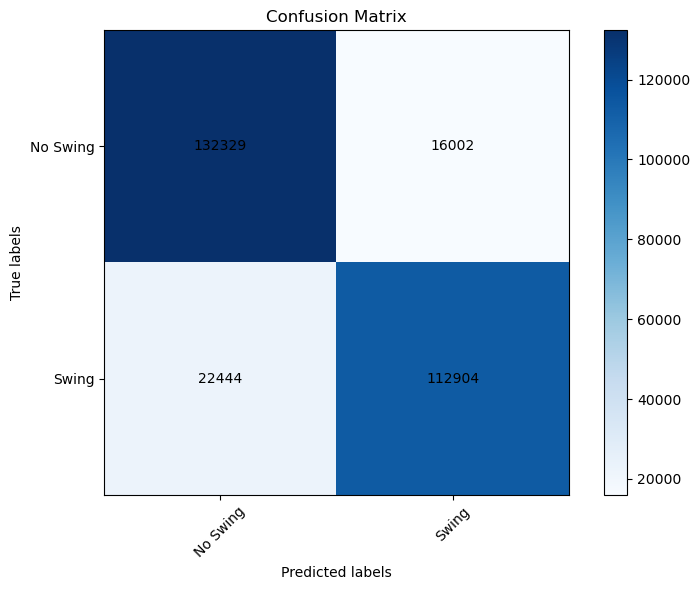

In [21]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred2)

classes = ['No Swing', 'Swing']

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.tight_layout()

# Add text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], horizontalalignment='center', verticalalignment='center', color='black')

plt.show()

In [27]:
# making year 3 prediction csv

# drop columns
columns_drop = ['season', 'pitch_id', 'batter', 'pitcher']
df3 = year3.drop(columns=columns_drop, axis=1)

# Replace missing values with the mean or mode
df3['release_speed'] = df3['release_speed'].fillna(df3['release_speed'].mean())
df3['pitch_type'] = df3['pitch_type'].fillna(df3['pitch_type'].mode()[0])
df3['pfx_x'] = df3['pfx_x'].fillna(df3['pfx_x'].mean())
df3['pfx_z'] = df3['pfx_z'].fillna(df3['pfx_z'].mean())
df3['plate_x'] = df3['plate_x'].fillna(df3['plate_x'].mean())
df3['plate_z'] = df3['plate_z'].fillna(df3['plate_z'].mean())
df3['sz_top'] = df3['sz_top'].fillna(df3['sz_top'].mean())
df3['sz_bot'] = df3['sz_bot'].fillna(df3['sz_bot'].mean())

# changing FO to PO to fit model
df3['pitch_type'] = df3['pitch_type'].replace('FO', 'PO')

# encoding catergorical
year3_df = pd.get_dummies(df3, columns=['stand', 'p_throws', 'pitch_type'], prefix=['stand', 'p_throws', 'pitch_type'])
encoded_cols = year3_df.columns[year3_df.columns.str.startswith(('stand_', 'p_throws_', 'pitch_type_'))]
year3_df[encoded_cols] = year3_df[encoded_cols].astype(int)

# scale data
X_year3 = scaler.fit_transform(year3_df)

# predictions
predicted_swing = clf2.predict_proba(X_year3)
year3['SwingProbability'] = predicted_swing[:,1]

# new validation CSV
year3.to_csv('validation.csv', index=False)

# Middle-Middle Pitches

In [ ]:
# filter middle pitches
center_x = 0
training['center_z'] = (training['sz_top'] + training['sz_bot']) / 2

middle_pitches = training[
    (training['plate_x'] >= center_x - 0.5) & (training['plate_x'] <= center_x + 0.5) &
    (training['plate_z'] >= training['center_z'] - 0.5) & (training['plate_z'] <= training['center_z'] + 0.5)
]

In [ ]:
middle_pitches.head(10)

,release_speed,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot,swing,...,pitch_type_FS,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV,center_z
2,94.800003,1,0,-0.62,1.16,0.31,2.40,3.41,1.56,1,...,0,0,0,0,0,0,0,0,0,2.485
6,95.400002,0,0,-0.58,0.98,-0.16,2.36,3.41,1.56,1,...,0,0,0,0,0,0,0,0,0,2.485
15,94.599998,2,1,-0.68,0.89,0.08,2.03,3.41,1.56,1,...,0,0,0,0,0,0,0,0,0,2.485
26,89.500000,3,2,0.41,0.95,-0.42,2.27,3.41,1.56,1,...,0,0,0,0,0,0,0,0,0,2.485
31,80.599998,2,2,-1.62,-0.59,0.39,2.99,3.55,1.63,1,...,0,0,0,0,0,0,0,1,0,2.590
32,83.000000,3,2,-1.71,-0.34,0.20,2.47,3.55,1.63,1,...,0,0,0,0,0,0,0,1,0,2.590
34,95.199997,1,0,-0.20,0.72,-0.07,2.44,3.41,1.56,1,...,0,0,0,0,0,0,0,0,0,2.485
52,91.400002,0,0,-1.25,1.15,-0.15,2.66,3.37,1.53,1,...,0,0,0,0,0,0,0,0,0,2.450
56,73.900002,1,1,0.13,-0.93,-0.02,2.68,3.43,1.67,0,...,0,0,0,0,0,0,0,0,0,2.550
57,74.300003,1,2,0.18,-0.95,0.27,2.04,3.47,1.59,1,...,0,0,0,0,0,0,0,0,0,2.530


In [ ]:
# split data
new_y_cols = ['swing', 'center_z']
X = middle_pitches.drop(columns=new_y_cols, axis=1)
y = middle_pitches['swing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X.columns

Index(['release_speed', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'sz_top', 'sz_bot', 'stand_L', 'stand_R', 'p_throws_L',
       'p_throws_R', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU',
       'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC', 'pitch_type_FF',
       'pitch_type_FS', 'pitch_type_KC', 'pitch_type_KN', 'pitch_type_PO',
       'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL', 'pitch_type_ST',
       'pitch_type_SV'],
      dtype='object')

In [ ]:
# lgm model
clf3 = lgb.LGBMClassifier()
clf3.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 156223, number of negative: 53645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 209868, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.744387 -> initscore=1.068896
[LightGBM] [Info] Start training from score 1.068896


LGBMClassifier()

In [ ]:
# prediction
y_pred3 = clf3.predict(X_test_scaled)
test_accuracy3 = accuracy_score(y_test, y_pred3)
print("Test Accuracy:", test_accuracy3) 

# predicting training data to check overfitting
y_pred_train3 = clf3.predict(X_train_scaled)
train_accuracy3 = accuracy_score(y_train, y_pred_train3)
print("Training Accuracy:", train_accuracy3) 

Test Accuracy: 0.8513923037337755
Training Accuracy: 0.8511445289420017


In [ ]:
clf3.feature_importances_

array([129, 120, 118, 215, 214, 168, 209, 818, 800,  74,   0,   0,  31,
        21,   0,   1,   9,   8,  13,  20,   0,   0,   0,   0,   0,  11,
        10,   4,   7], dtype=int32)

In [ ]:
# sorted feature importances
feature_importances = clf3.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
feature_names = X.columns.tolist()
sorted_feature_names = [feature_names[i] for i in sorted_indices]

for feature_name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"{feature_name}: {importance}")

sz_top: 818
sz_bot: 800
pfx_x: 215
pfx_z: 214
plate_z: 209
plate_x: 168
release_speed: 129
balls: 120
strikes: 118
stand_L: 74
p_throws_R: 31
pitch_type_CH: 21
pitch_type_FF: 20
pitch_type_FC: 13
pitch_type_SI: 11
pitch_type_SL: 10
pitch_type_EP: 9
pitch_type_FA: 8
pitch_type_SV: 7
pitch_type_ST: 4
pitch_type_CU: 1
stand_R: 0
p_throws_L: 0
pitch_type_FS: 0
pitch_type_KC: 0
pitch_type_KN: 0
pitch_type_PO: 0
pitch_type_SC: 0
pitch_type_CS: 0
